#**Install Library**

In [ ]:
!pip install basemap-data-hires
!pip install seaborn
!pip install basemap numpy pandas scipy
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 MB 10.9 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 860.7/860.7 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 47.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 23.4 MB/s eta 0:00:00


#**Import Library**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm, Normalize
from scipy.stats import linregress

#**Read Dataset**

In [ ]:
dataset = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Indonesia/QueryCountryIndonesia(1910-2016)USGS.csv"
data_gempa = pd.read_csv(dataset)
data_gempa.head(5)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2016-12-31T17:22:51.700Z,1.0439,126.5326,42.38,4.0,mb,NaN,197.0,0.876,0.98,...,2017-03-23T22:52:11.040Z,"97km WNW of Kota Ternate, Indonesia",earthquake,11.8,27.3,0.183,8.0,reviewed,us,us
1,2016-12-31T07:21:08.220Z,-6.0786,130.0318,137.85,4.6,mb,NaN,82.0,2.271,0.86,...,2017-03-23T22:52:10.040Z,"250km NW of Saumlaki, Indonesia",earthquake,8.9,8.2,0.122,20.0,reviewed,us,us
2,2016-12-30T08:24:53.620Z,-9.1767,123.5689,116.02,4.6,mb,NaN,59.0,0.897,0.89,...,2017-03-23T22:52:09.040Z,"51km NNW of Naisano Dua, Indonesia",earthquake,7.7,6.6,0.110,25.0,reviewed,us,us
3,2016-12-30T07:10:05.390Z,1.7358,126.5028,42.15,5.0,mb,NaN,92.0,1.289,0.95,...,2017-03-23T22:52:09.040Z,"142km NW of Kota Ternate, Indonesia",earthquake,7.8,7.4,0.075,57.0,reviewed,us,us
4,2016-12-30T06:41:20.480Z,-9.1597,118.7325,105.58,4.4,mb,NaN,81.0,3.502,0.64,...,2017-03-23T22:52:09.040Z,"45km SSE of Tolotangga, Indonesia",earthquake,6.7,8.6,0.134,16.0,reviewed,us,us


#**values-b by Depth**

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


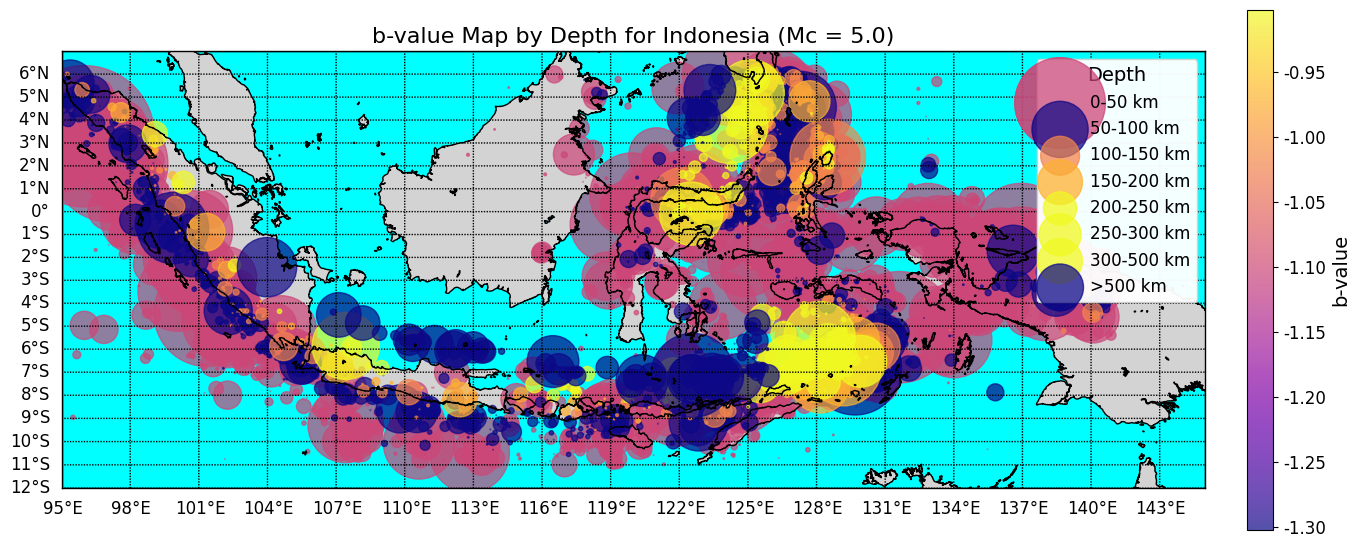

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize

# Load earthquake dataset
dataset = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Indonesia/QueryCountryIndonesia(1910-2016)USGS.csv"
data_gempa = pd.read_csv(dataset)

# Remove rows with NaN values in specific columns
data_gempa = data_gempa.dropna(subset=['mag', 'latitude', 'longitude', 'depth'])

# Set geographical boundaries for Indonesia
lon_min, lon_max = 95, 145
lat_min, lat_max = -12, 7

# Filter data for Indonesia
data_indonesia = data_gempa[(data_gempa['longitude'] >= lon_min) & (data_gempa['longitude'] <= lon_max) &
                            (data_gempa['latitude'] >= lat_min) & (data_gempa['latitude'] <= lat_max)]

# Magnitude of completeness (Mc)
mc = 5.0

# Calculate b-value for all data
b_value_all = np.log10(np.exp(1)) / (np.mean(data_indonesia['mag']) - mc)

# Create a map of b-value distribution based on depth for Indonesia
plt.figure(figsize=(18, 9))
m = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max, llcrnrlon=lon_min, urcrnrlon=lon_max, resolution='h')
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='lightgray', lake_color='aqua')
m.drawcoastlines()
m.drawparallels(np.arange(lat_min, lat_max+1, 1), labels=[1, 0, 0, 0], fontsize=12)
m.drawmeridians(np.arange(lon_min, lon_max+1, 3), labels=[0, 0, 0, 1], fontsize=12)  # Changed meridian intervals to 3 degrees

# Split earthquake data based on depth
depth_bins = [0, 50, 100, 150, 200, 250, 300, 500, 1000]
depth_labels = ['0-50 km', '50-100 km', '100-150 km', '150-200 km', '200-250 km', '250-300 km', '300-500 km', '>500 km']

for i in range(len(depth_bins)-1):
    depth_range = data_indonesia[(data_indonesia['depth'] >= depth_bins[i]) & (data_indonesia['depth'] < depth_bins[i+1])]
    if len(depth_range) > 0:
        b_value_depth = np.log10(np.exp(1)) / (np.mean(depth_range['mag']) - mc)
        x, y = m(depth_range['longitude'].values, depth_range['latitude'].values)
        c = m.scatter(x, y, c=[b_value_depth]*len(x), cmap='plasma',
                      norm=Normalize(vmin=b_value_all - 0.2, vmax=b_value_all + 0.2),
                      s=150*(depth_range['mag']-mc)**3, alpha=0.7, label=depth_labels[i])

# Add b-value scale on the color axis of the map
cbar_b = plt.colorbar(c, orientation='vertical', pad=0.03, shrink=0.75, format='%.2f')
cbar_b.set_label("b-value", fontsize=14)
cbar_b.ax.tick_params(labelsize=12)

# Add a legend for depth
depth_legend = plt.legend(loc='upper right', fontsize=12, title='Depth', title_fontsize=14)
plt.gca().add_artist(depth_legend)

plt.title(f"b-value Map by Depth for Indonesia (Mc = {mc})", fontsize=16)
plt.show()


#**Temporal variation using values-b**

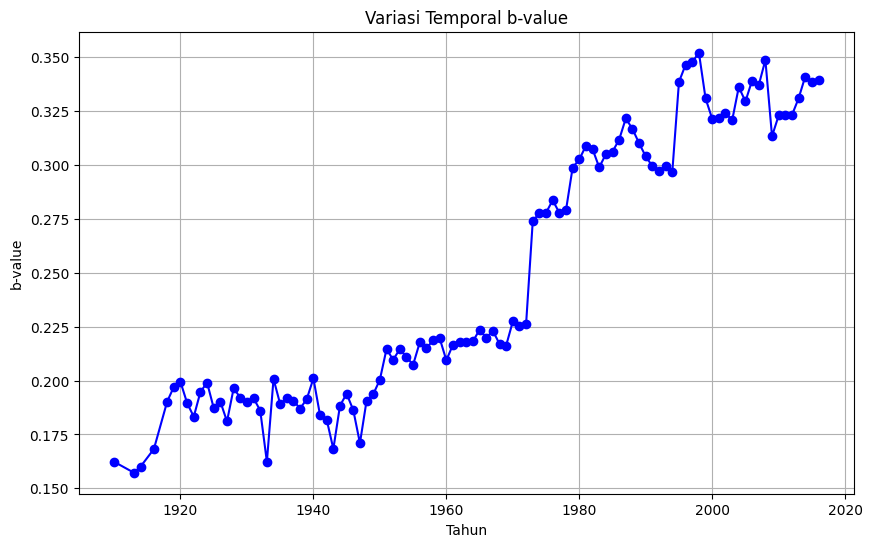

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset gempa dari URL
dataset = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Indonesia/QueryCountryIndonesia(1910-2016)USGS.csv"

# Membaca dataset gempa
data_gempa = pd.read_csv(dataset)

# Mengubah kolom 'time' menjadi tipe data datetime
data_gempa['time'] = pd.to_datetime(data_gempa['time'])

# Membuat kolom 'Tahun' berdasarkan tahun pada kolom 'time'
data_gempa['Tahun'] = data_gempa['time'].dt.year

# Hitung b-value untuk setiap tahun
years = sorted(data_gempa['Tahun'].unique())
b_values = []

for year in years:
    data_year = data_gempa[data_gempa['Tahun'] == year]
    magnitudes = data_year['mag'].values
    N = len(magnitudes)
    M0 = 10**(1.5 * (magnitudes.mean() - 1.44))
    b_value = (1 / (magnitudes - 1.44)).sum() / N
    b_values.append(b_value)

# Plot hasil variasi temporal b-value
plt.figure(figsize=(10, 6))
plt.plot(years, b_values, marker='o', linestyle='-', color='blue')
plt.xlabel('Year')
plt.ylabel('b-value')
plt.title('b-value Temporal Variation')
plt.grid(True)
plt.show()


#**b temporal and spatial distribution**

##**Sumatra Region**

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


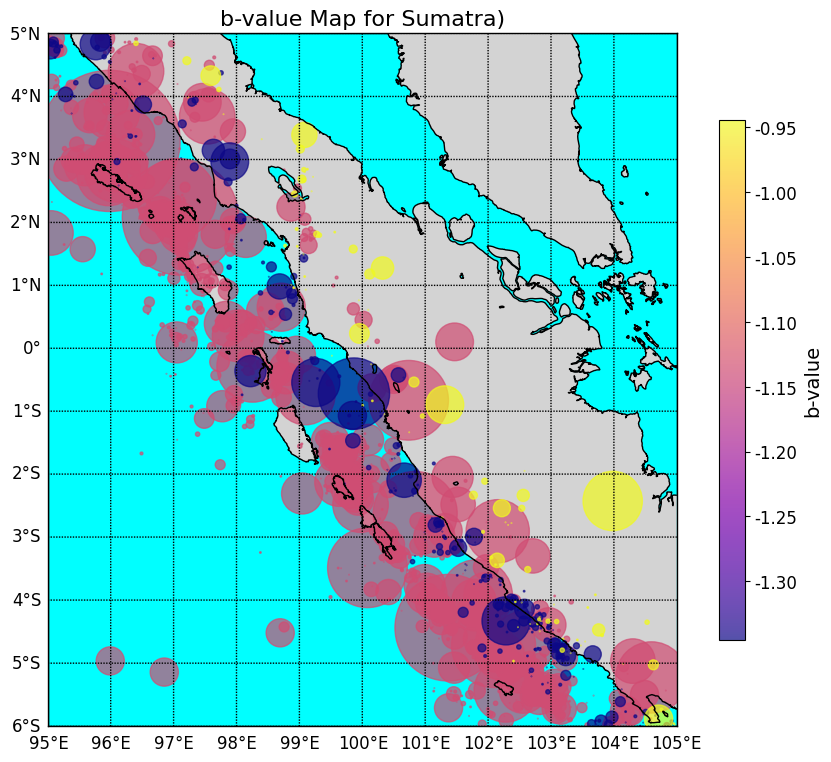

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize

# Load earthquake dataset
dataset = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Indonesia/QueryCountryIndonesia(1910-2016)USGS.csv"
data_gempa = pd.read_csv(dataset)

# Set geographical boundaries for Sumatra
lon_min, lon_max = 95, 105
lat_min, lat_max = -6, 5

# Filter data for Sumatra
data_sumatra = data_gempa[(data_gempa['longitude'] >= lon_min) & (data_gempa['longitude'] <= lon_max) &
                          (data_gempa['latitude'] >= lat_min) & (data_gempa['latitude'] <= lat_max)]

# Calculate the b-value for all data in Sumatra
mc = 5.0
b_value_all = np.log10(np.exp(1)) / (np.mean(data_sumatra['mag']) - mc)

# Create a map of b-value distribution based on depth for Sumatra
plt.figure(figsize=(18, 9))
m = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max, llcrnrlon=lon_min, urcrnrlon=lon_max, resolution='h')
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='lightgray', lake_color='aqua')
m.drawcoastlines()
m.drawparallels(np.arange(lat_min, lat_max+1, 1), labels=[1, 0, 0, 0], fontsize=12)
m.drawmeridians(np.arange(lon_min, lon_max+1, 1), labels=[0, 0, 0, 1], fontsize=12)  # Set meridian intervals to 1 degree

# Split earthquake data based on depth for Sumatra
depth_bins = [0, 50, 100, 150, 200, 250, 300, 500, 1000]
depth_labels = ['0-50 km', '50-100 km', '100-150 km', '150-200 km', '200-250 km', '250-300 km', '300-500 km', '>500 km']

for i in range(len(depth_bins)-1):
    depth_range = data_sumatra[(data_sumatra['depth'] >= depth_bins[i]) & (data_sumatra['depth'] < depth_bins[i+1])]
    if len(depth_range) > 0:
        b_value_depth = np.log10(np.exp(1)) / (np.mean(depth_range['mag']) - mc)
        x, y = m(depth_range['longitude'].values, depth_range['latitude'].values)
        c = m.scatter(x, y, c=[b_value_depth]*len(x), cmap='plasma',
                      norm=Normalize(vmin=b_value_all - 0.2, vmax=b_value_all + 0.2),
                      s=150*(depth_range['mag']-mc)**3, alpha=0.7, label=depth_labels[i])

# Add b-value scale on the color axis of the map
cbar_b = plt.colorbar(c, orientation='vertical', pad=0.03, shrink=0.75, format='%.2f')
cbar_b.set_label("b-value", fontsize=14)
cbar_b.ax.tick_params(labelsize=12)

plt.title(f"b-value Map for Sumatra)", fontsize=16)
plt.show()


##**Jawa Region**

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


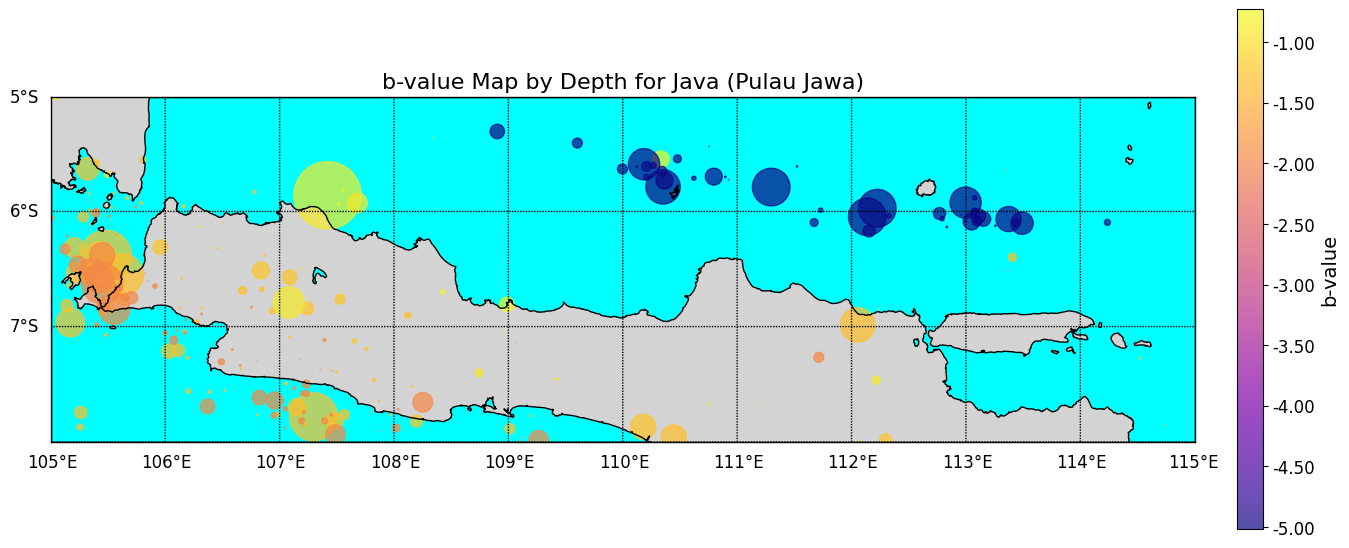

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize

# Load earthquake dataset
dataset = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Indonesia/QueryCountryIndonesia(1910-2016)USGS.csv"
data_gempa = pd.read_csv(dataset)

# Set geographical boundaries for Java
lon_min, lon_max = 105, 115
lat_min, lat_max = -8, -5

# Filter data for Java (Pulau Jawa)
data_java = data_gempa[(data_gempa['longitude'] >= lon_min) & (data_gempa['longitude'] <= lon_max) &
                       (data_gempa['latitude'] >= lat_min) & (data_gempa['latitude'] <= lat_max)]

# Calculate the b-value for all data in Java
mc = 5.0
b_value_all = np.log10(np.exp(1)) / (np.mean(data_java['mag']) - mc)

# Create a map of b-value distribution based on depth for Java
plt.figure(figsize=(18, 9))
m = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max, llcrnrlon=lon_min, urcrnrlon=lon_max, resolution='h')
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='lightgray', lake_color='aqua')
m.drawcoastlines()
m.drawparallels(np.arange(lat_min, lat_max+1, 1), labels=[1, 0, 0, 0], fontsize=12)
m.drawmeridians(np.arange(lon_min, lon_max+1, 1), labels=[0, 0, 0, 1], fontsize=12)  # Set meridian intervals to 1 degree

# Split earthquake data based on depth for Java
depth_bins = [0, 50, 100, 150, 200, 250, 300, 500, 1000]
depth_labels = ['0-50 km', '50-100 km', '100-150 km', '150-200 km', '200-250 km', '250-300 km', '300-500 km', '>500 km']

b_value_depth = []  # Array to store b_values based on depth

for i in range(len(depth_bins)-1):
    depth_range = data_java[(data_java['depth'] >= depth_bins[i]) & (data_java['depth'] < depth_bins[i+1])]
    if len(depth_range) > 0:
        b_value_depth.append(np.log10(np.exp(1)) / (np.mean(depth_range['mag']) - mc))
    else:
        b_value_depth.append(np.nan)

b_value_depth = np.array(b_value_depth)  # Convert list to NumPy array

for i in range(len(depth_bins)-1):
    depth_range = data_java[(data_java['depth'] >= depth_bins[i]) & (data_java['depth'] < depth_bins[i+1])]
    if len(depth_range) > 0:
        x, y = m(depth_range['longitude'].values, depth_range['latitude'].values)
        norm = Normalize(vmin=b_value_depth.min(), vmax=b_value_depth.max())
        c = m.scatter(x, y, c=[b_value_depth[i]]*len(x), cmap='plasma',
                      norm=norm,
                      s=150*(depth_range['mag']-mc)**3, alpha=0.7, label=depth_labels[i])

# Add b-value scale on the color axis of the map
cbar_b = plt.colorbar(c, orientation='vertical', pad=0.03, shrink=0.75, format='%.2f')
cbar_b.set_label("b-value", fontsize=14)
cbar_b.ax.tick_params(labelsize=12)

plt.title(f"b-value Map by Depth for Java (Pulau Jawa)", fontsize=16)
plt.show()


##**Sulawesi Region**

# **Variation b-value**

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


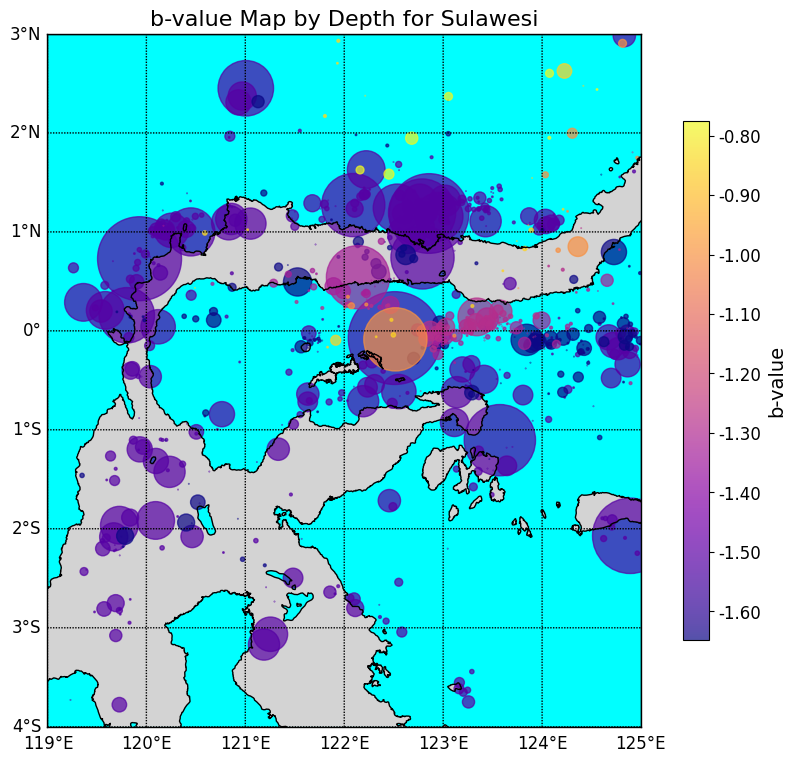

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize

# Load earthquake dataset
dataset = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Indonesia/QueryCountryIndonesia(1910-2016)USGS.csv"
data_gempa = pd.read_csv(dataset)

# Set geographical boundaries for Sulawesi
lon_min, lon_max = 119, 125
lat_min, lat_max = -4, 3

# Filter data for Sulawesi
data_sulawesi = data_gempa[(data_gempa['longitude'] >= lon_min) & (data_gempa['longitude'] <= lon_max) &
                           (data_gempa['latitude'] >= lat_min) & (data_gempa['latitude'] <= lat_max)]

# Calculate the b-value for all data in Sulawesi
mc = 5.0
b_value_all = np.log10(np.exp(1)) / (np.mean(data_sulawesi['mag']) - mc)

# Create a map of b-value distribution based on depth for Sulawesi
plt.figure(figsize=(18, 9))
m = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max, llcrnrlon=lon_min, urcrnrlon=lon_max, resolution='h')
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='lightgray', lake_color='aqua')
m.drawcoastlines()
m.drawparallels(np.arange(lat_min, lat_max+1, 1), labels=[1, 0, 0, 0], fontsize=12)
m.drawmeridians(np.arange(lon_min, lon_max+1, 1), labels=[0, 0, 0, 1], fontsize=12)  # Set meridian intervals to 1 degree

# Split earthquake data based on depth for Sulawesi
depth_bins = [0, 50, 100, 150, 200, 250, 300, 500, 1000]
depth_labels = ['0-50 km', '50-100 km', '100-150 km', '150-200 km', '200-250 km', '250-300 km', '300-500 km', '>500 km']

b_value_depth = []  # Array to store b_values based on depth

for i in range(len(depth_bins)-1):
    depth_range = data_sulawesi[(data_sulawesi['depth'] >= depth_bins[i]) & (data_sulawesi['depth'] < depth_bins[i+1])]
    if len(depth_range) > 0:
        b_value_depth.append(np.log10(np.exp(1)) / (np.mean(depth_range['mag']) - mc))
    else:
        b_value_depth.append(np.nan)

b_value_depth = np.array(b_value_depth)  # Convert list to NumPy array

for i in range(len(depth_bins)-1):
    depth_range = data_sulawesi[(data_sulawesi['depth'] >= depth_bins[i]) & (data_sulawesi['depth'] < depth_bins[i+1])]
    if len(depth_range) > 0:
        x, y = m(depth_range['longitude'].values, depth_range['latitude'].values)
        norm = Normalize(vmin=b_value_depth.min(), vmax=b_value_depth.max())
        c = m.scatter(x, y, c=[b_value_depth[i]]*len(x), cmap='plasma',
                      norm=norm,
                      s=150*(depth_range['mag']-mc)**3, alpha=0.7, label=depth_labels[i])

# Add b-value scale on the color axis of the map
cbar_b = plt.colorbar(c, orientation='vertical', pad=0.03, shrink=0.75, format='%.2f')
cbar_b.set_label("b-value", fontsize=14)
cbar_b.ax.tick_params(labelsize=12)

plt.title(f"b-value Map by Depth for Sulawesi", fontsize=16)
plt.show()


/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


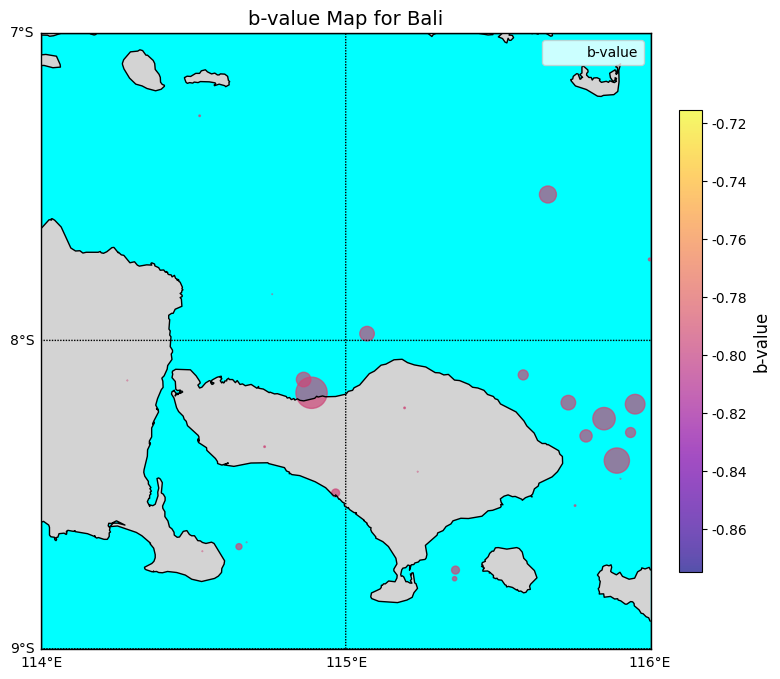

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


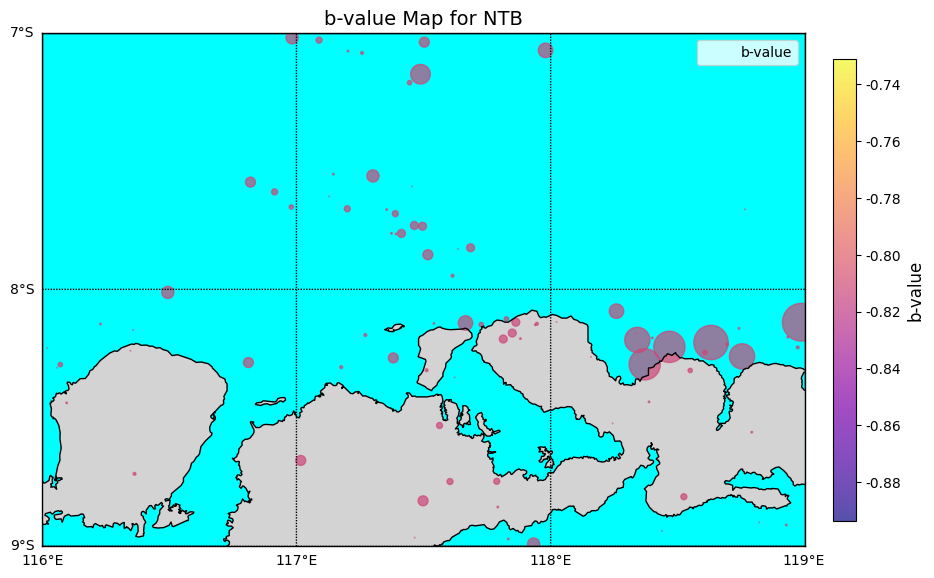

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


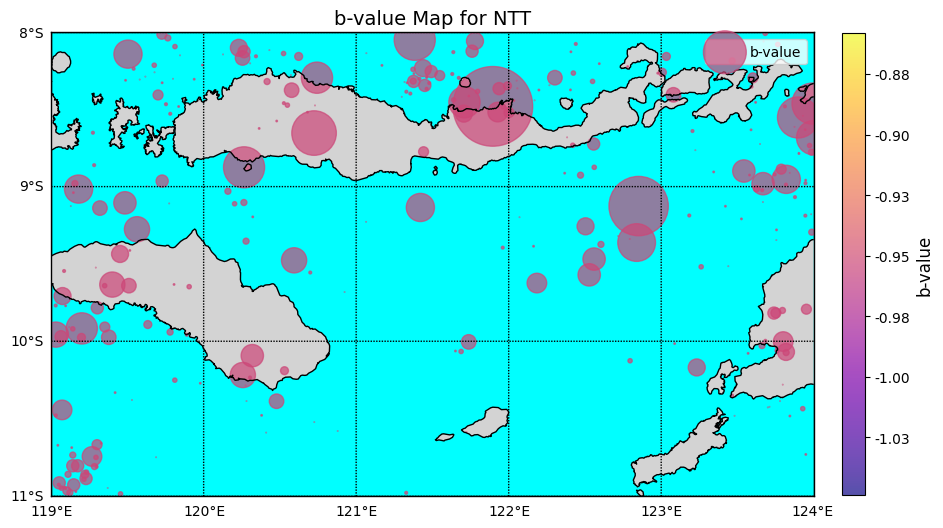

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Load earthquake dataset
dataset = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Indonesia/QueryCountryIndonesia(1910-2016)USGS.csv"
data_gempa = pd.read_csv(dataset)

# Define geographical boundaries for Bali, NTB, and NTT
regions = {
    'Bali': {'lon_min': 114, 'lon_max': 116, 'lat_min': -9, 'lat_max': -7},
    'NTB': {'lon_min': 116, 'lon_max': 119, 'lat_min': -9, 'lat_max': -7},
    'NTT': {'lon_min': 119, 'lon_max': 124, 'lat_min': -11, 'lat_max': -8}
}

# Function to calculate b-value for a region
def calculate_b_value(region_data):
    mc = 5.0
    return np.log10(np.exp(1)) / (np.mean(region_data['mag']) - mc)

# Function to plot b-value map for a specific region
def plot_b_value_map(region):
    lon_min, lon_max = regions[region]['lon_min'], regions[region]['lon_max']
    lat_min, lat_max = regions[region]['lat_min'], regions[region]['lat_max']

    data_region = data_gempa[(data_gempa['longitude'] >= lon_min) & (data_gempa['longitude'] <= lon_max) &
                             (data_gempa['latitude'] >= lat_min) & (data_gempa['latitude'] <= lat_max)]

    plt.figure(figsize=(12, 8))
    m = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max, llcrnrlon=lon_min, urcrnrlon=lon_max, resolution='h')
    m.drawmapboundary(fill_color='aqua')
    m.fillcontinents(color='lightgray', lake_color='aqua')
    m.drawcoastlines()
    m.drawparallels(np.arange(lat_min, lat_max+1, 1), labels=[1, 0, 0, 0], fontsize=10)
    m.drawmeridians(np.arange(lon_min, lon_max+1, 1), labels=[0, 0, 0, 1], fontsize=10)

    x, y = m(data_region['longitude'].values, data_region['latitude'].values)
    b_values = [calculate_b_value(data_region)] * len(data_region)  # Calculate b-value for the entire region
    sc = plt.scatter(x, y, c=b_values, cmap='plasma', s=150*(data_region['mag']-5)**3, alpha=0.7, label='b-value')

    cbar = plt.colorbar(sc, orientation='vertical', pad=0.03, shrink=0.75, format='%.2f')
    cbar.set_label("b-value", fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    plt.title(f"b-value Map for {region}", fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.show()

# Visualize b-value maps for each region
plot_b_value_map('Bali')
plot_b_value_map('NTB')
plot_b_value_map('NTT')


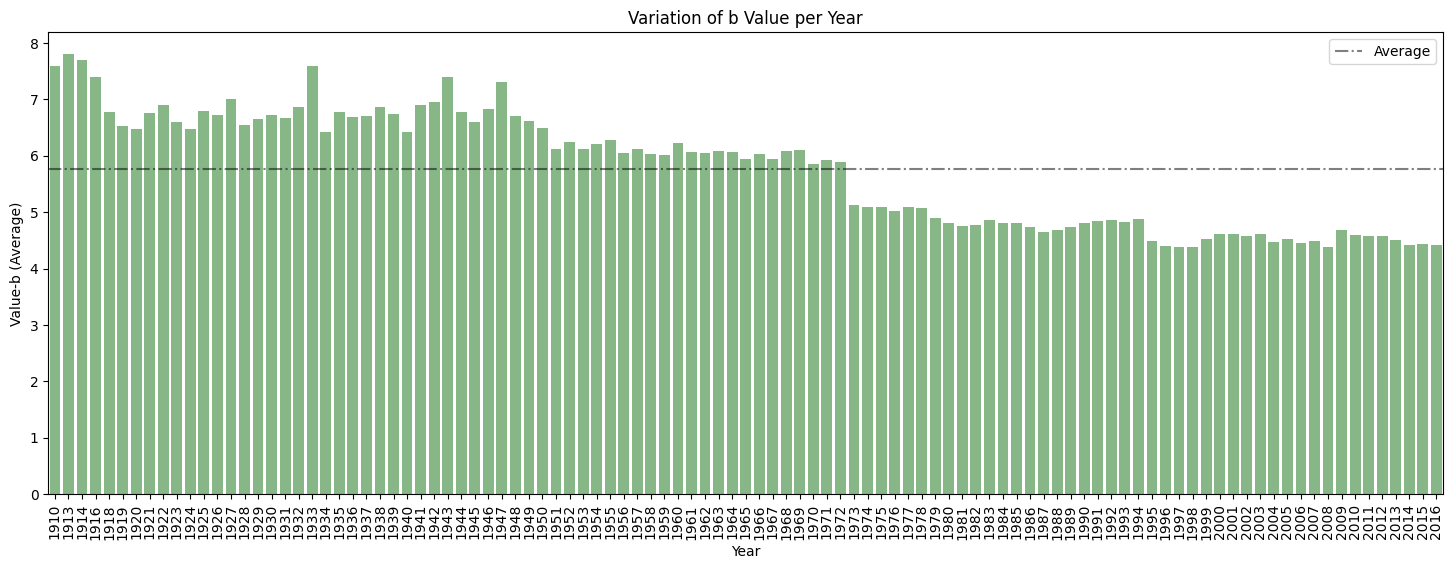

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load earthquake dataset
dataset = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Indonesia/QueryCountryIndonesia(1910-2016)USGS.csv"
df = pd.read_csv(dataset)

# Menghitung rata-rata nilai b per tahun
df['dt_time'] = pd.to_datetime(df['time'])
df['year'] = df['dt_time'].dt.year
b_value_mean = df.groupby('year')['mag'].mean()

# Plot Bar Chart
plt.figure(figsize=(18, 6))
sns.barplot(x=b_value_mean.index, y=b_value_mean.values, alpha=0.5, color='green')
plt.axhline(y=b_value_mean.mean(), color='k', linestyle='-.', alpha=0.5, label='Average')
plt.xlabel('Year')
plt.ylabel('Value-b (Average)')
plt.xticks(rotation='vertical')
plt.legend()
plt.title('Variation of b Value per Year')
plt.show()
